# Citation

Much of the code and examples are copied/modified from 

> Blueprints for Text Analytics Using Python by Jens Albrecht, Sidharth Ramachandran, and Christian Winkler (O'Reilly, 2021), 978-1-492-07408-3.
>

- https://github.com/blueprints-for-text-analytics-python/blueprints-text
- https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch08/Topic_Modeling_Clustering.ipynb

---

# Setup

In [4]:
cd ../..

/Users/shanekercheval/repos/nlp-template


In [5]:
%run "source/config/notebook_settings.py"

In [6]:
pd.set_option('display.max_colwidth', None)

In [7]:
from source.library.utilities import Timer, get_logger
from source.library.text_analysis import count_tokens, tf_idf, get_context_from_keyword, count_keywords, count_keywords_by, impurity

In [8]:
with Timer("Loading Data"):
    path = 'artifacts/data/processed/un-general-debates-paragraphs.pkl'
    paragraphs = pd.read_pickle(path)

Started: Loading Data
Finished (0.23 seconds)


---

# Exploratory Data Analysis

This section provides a basic exploration of the text and dataset.

## Dataset Summary

In [10]:
hlp.pandas.numeric_summary(paragraphs)

,# of Non-Nulls,# of Nulls,% Nulls,# of Zeros,% Zeros,Mean,St Dev.,Coef of Var,Skewness,Kurtosis,Min,10%,25%,50%,75%,90%,Max
year,"279,045",0,0.0%,0,0.0%,"1,992.4",12.6,0.0,0.1,-1.1,"1,970","1,975.0","1,982.0","1,993.0","2,003.0","2,010.0","2,015"


In [11]:
hlp.pandas.non_numeric_summary(paragraphs)

,# of Non-Nulls,# of Nulls,% Nulls,Most Freq. Value,# of Unique,% Unique
country,"279,045",0,0.0%,Russian Federation,199,0.1%
text,"279,045",0,0.0%,The President returned to the [...],"278,820",99.9%


In [12]:
assert not (paragraphs['text'].str.strip() == '').any()

# Prep

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from spacy.lang.en.stop_words import STOP_WORDS as stopwords

In [194]:
stopwords |= {'united', 'nations', 'nation'}

## Sample

In [21]:
paragraphs = paragraphs.sample(2000)
#paragraphs.to_pickle('source/tests/test_files/datasets/un_debates_paragraphs_sample.pkl')

## TF

`TF` seems to be used with `LDA` rather than `TF-IDF`

In [214]:
with Timer("Calculating TF (uni-grams and bi-grams) for UN Debate Paragraphs"):
    count_vectorizer_unigrams = CountVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
    count_vectors_unigrams = count_vectorizer_unigrams.fit_transform(paragraphs["text"])
    count_vectors_unigrams.shape

    count_vectorizer_bigrams = CountVectorizer(stop_words=stopwords, ngram_range=(2, 3), min_df=5, max_df=0.7)
    count_vectors_bigrams = count_vectorizer_bigrams.fit_transform(paragraphs["text"])
    count_vectors_bigrams.shape

Started: Calculating TF (uni-grams and bi-grams) for UN Debate Paragraphs
Finished (0.23 seconds)


/Users/shanekercheval/repos/nlp-template/.venv/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.



## TF-IDF

In [215]:
with Timer("Calculating TF-IDF (uni-grams and bi-grams) for UN Debate Paragraphs"):
    tfidf_vectorizer_unigrams = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
    tfidf_vectors_unigrams = tfidf_vectorizer_unigrams.fit_transform(paragraphs["text"])
    tfidf_vectors_unigrams.shape
    
    tfidf_vectorizer_bigrams = TfidfVectorizer(stop_words=stopwords, ngram_range=(2, 3), min_df=5, max_df=0.7)
    tfidf_vectors_bigrams = tfidf_vectorizer_bigrams.fit_transform(paragraphs["text"])
    tfidf_vectors_bigrams.shape

Started: Calculating TF-IDF (uni-grams and bi-grams) for UN Debate Paragraphs
Finished (0.23 seconds)


# Topic Modeling

In [216]:
import matplotlib.pyplot as plt
def plot_top_words(model, feature_names, n_top_words, title):
    """
    https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py
    """
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()



In [217]:
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## NMF

### Uni-grams

In [218]:
from sklearn.decomposition import NMF

nmf_unigrams = NMF(n_components=10, random_state=42)
# see Blueprints pg. 214 for explaination of W X H
w_matrix_unigrams = nmf_unigrams.fit_transform(tfidf_vectors_unigrams)
h_matrix_unigrams = nmf_unigrams.components_
word_names = tfidf_vectorizer_unigrams.get_feature_names_out()

/Users/shanekercheval/repos/nlp-template/.venv/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).



In [219]:
print(w_matrix_unigrams.shape)
print(h_matrix_unigrams.shape)

(2000, 10)
(10, 2671)


Get Topic Weightings for First Doc

In [220]:
# topics for first document 
w_first_doc = w_matrix_unigrams[0, ]
w_first_doc

array([0.        , 0.        , 0.        , 0.00060701, 0.        ,
       0.07230306, 0.0884645 , 0.0321044 , 0.07646107, 0.        ])

In [221]:
# Should be the same values as before
predictions_first_doc = nmf_unigrams.transform(tfidf_vectors_unigrams[0,])
predictions_first_doc

array([[0.        , 0.        , 0.        , 0.00060729, 0.        ,
        0.07230273, 0.088463  , 0.03210424, 0.07646083, 0.        ]])

In [222]:
[abs(round(x, 4)) for x in (w_first_doc - predictions_first_doc).tolist()[0]]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

---

Get Top 10 Words for First Topic

In [223]:
first_topic = h_matrix_unigrams[0,]
first_topic.shape

(2671,)

In [224]:
largest_word_values = first_topic.argsort()[::-1]
largest_word_values[0:10]

array([1359, 2210,  505,  620, 2342, 1782, 2440, 2071,  611,  440])

In [225]:
word_names[largest_word_values[0:10]]

array(['international', 'security', 'community', 'council', 'states',
       'peace', 'terrorism', 'relations', 'cooperation', 'charter'],
      dtype=object)

---

Size of Topics (Percent of all Documents)

In [226]:
w_matrix_unigrams.sum(axis=0)/w_matrix_unigrams.sum()*100.0

array([10.90046864, 10.60465437,  8.62268368,  6.55221134,  6.53918628,
        6.48643855,  8.59759819, 15.26706779, 11.72335611, 14.70633507])

---

In [227]:
def topics_to_dictionary(model, features, num_top_words=10):
    topics = dict()
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        topics[topic + 1] = [(features[largest[i]], abs(words[largest[i]]*100.0/total)) for i in range(0, num_top_words)]
    return topics

In [228]:
topic_dictionary = topics_to_dictionary(nmf_unigrams, tfidf_vectorizer_unigrams.get_feature_names_out())
#topic_dictionary

In [229]:
name_lookup = {topic:' | '.join([y[0] for y in x[0:3]]) for topic, x in topic_dictionary.items()}

In [230]:
def topic_dictionary_to_names(topic_dictionary: dict, num_words_in_name: int=3):
    return {topic:' | '.join([y[0] for y in x[0:num_words_in_name]]) for topic, x in topic_dictionary.items()}

name_lookup = topic_dictionary_to_names(topic_dictionary, num_words_in_name=2)
name_lookup

{1: 'international | security',
 2: 'session | general',
 3: 'east | middle',
 4: 'nuclear | weapons',
 5: 'africa | south',
 6: 'rights | human',
 7: 'countries | developing',
 8: 'world | new',
 9: 'development | economic',
 10: 'people | country'}

In [231]:
def topics_to_dataframe(model, features: list, num_top_words: int = 10, num_words_in_name: int = 2) -> pd.DataFrame:
    topic_dictionary = topics_to_dictionary(model, features, num_top_words)
    name_lookup = topic_dictionary_to_names(topic_dictionary, num_words_in_name=num_words_in_name)
    
    topic_words = pd.DataFrame(topic_dictionary)
    topics = topic_words.columns
    topic_words = topic_words.reset_index().rename(columns={'index': 'word'})
    topic_words = pd.melt(topic_words, id_vars='word', value_vars=list(topics), var_name='topic')
    topic_words = topic_words.assign(**pd.DataFrame(topic_words['value'].tolist(), columns=['words', 'value']))
    topic_words['label'] = topic_words['topic'].apply(lambda x: name_lookup[x])
    return topic_words

topic_df = topics_to_dataframe(
    model=nmf_unigrams,
    features=tfidf_vectorizer_unigrams.get_feature_names_out(),
    num_top_words=10,
    num_words_in_name=2,
)
topic_df

,word,topic,value,words,label
0,0,1,3.43,international,international | security
1,1,1,2.08,security,international | security
2,2,1,1.46,community,international | security
3,3,1,1.35,council,international | security
4,4,1,1.21,states,international | security
...,...,...,...,...,...
95,5,10,0.85,independence,people | country
96,6,10,0.69,foreign,people | country
97,7,10,0.64,support,people | country
98,8,10,0.62,national,people | country


In [232]:
# topic_words = pd.DataFrame(topic_dictionary)
# topics = topic_words.columns
# topic_words = topic_words.reset_index().rename(columns={'index': 'word'})
# topic_words = pd.melt(topic_words, id_vars='word', value_vars=list(topics), var_name='topic')
# topic_words = topic_words.assign(**pd.DataFrame(topic_words['value'].tolist(), columns=['words', 'value']))
# topic_words['label'] = topic_words['topic'].apply(lambda x: name_lookup[x])
# topic_words

In [233]:
import plotly_express as px

fig = px.bar(
    topic_df,
    x='value',
    y='words',
    facet_col='label',
    facet_col_wrap=3,
    facet_col_spacing=0.2,
    labels={
        'words': '',
        'label': '',
    },
    width=900,
    height=1000,
    title="Topics in NMF model (Unigrams)"
)
fig.update_yaxes(matches=None, showticklabels=True, autorange="reversed")
#fig.update_xaxes(matches=None)
fig.show()

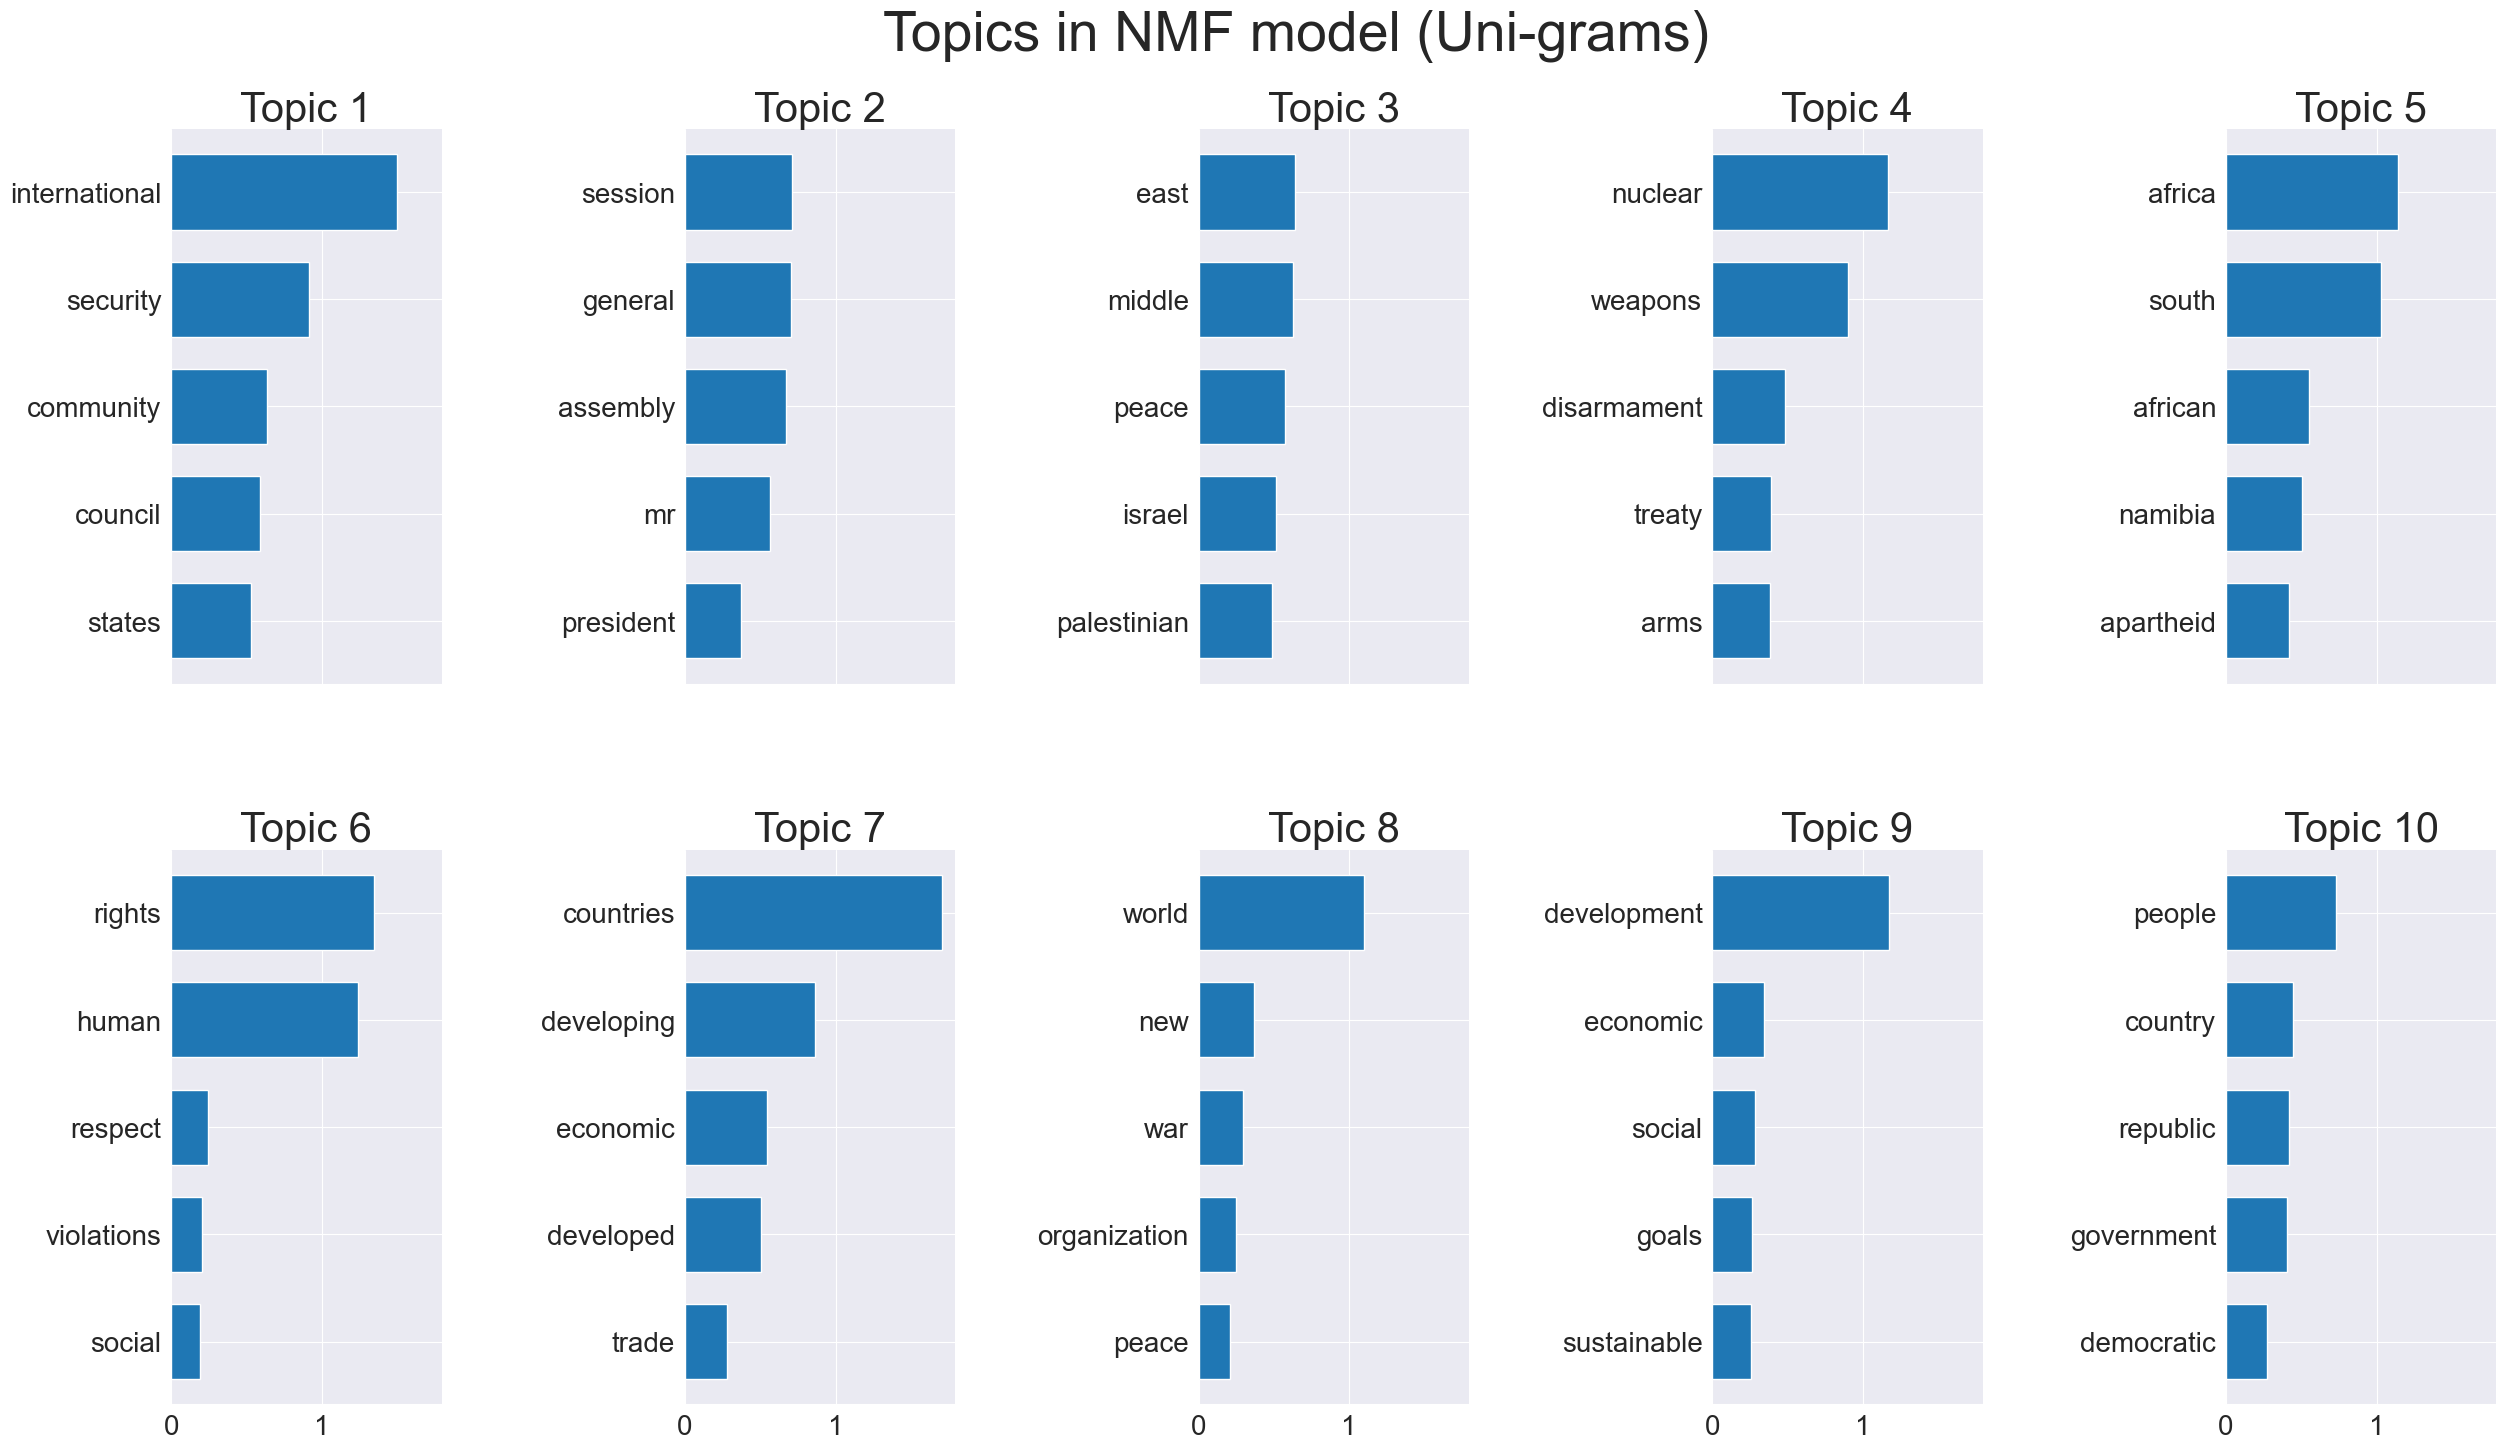

In [234]:
plot_top_words(
    model=nmf_unigrams,
    feature_names=tfidf_vectorizer_unigrams.get_feature_names_out(),
    n_top_words=5,
    title="Topics in NMF model (Uni-grams)"
)

---

### Bigrams

In [236]:
nmf_bigrams = NMF(n_components=10, random_state=42)
# see Blueprints pg. 214 for explaination of W X H
w_matrix_bigrams = nmf_bigrams.fit_transform(tfidf_vectors_bigrams)
h_matrix_bigrams = nmf_bigrams.components_
word_names = tfidf_vectorizer_bigrams.get_feature_names_out()

/Users/shanekercheval/repos/nlp-template/.venv/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).



In [61]:
#display_topics(nmf_para_model_bigrams, tfidf_para_vectorizer_bigrams.get_feature_names())

In [239]:

topic_df = topics_to_dataframe(
    model=nmf_bigrams,
    features=tfidf_vectorizer_bigrams.get_feature_names_out(),
    num_top_words=10,
    num_words_in_name=2,
)
topic_df

,word,topic,value,words,label
0,0,1,37.60,human rights,human rights | economic social
1,1,1,2.73,economic social,human rights | economic social
2,2,1,2.49,respect human,human rights | economic social
3,3,1,2.47,respect human rights,human rights | economic social
4,4,1,2.44,rule law,human rights | economic social
...,...,...,...,...,...
95,5,10,1.36,economic social,co operation | international co operation
96,6,10,1.23,north south,co operation | international co operation
97,7,10,1.15,international relations,co operation | international co operation
98,8,10,0.99,security co,co operation | international co operation


In [242]:
import plotly_express as px

fig = px.bar(
    topic_df,
    x='value',
    y='words',
    facet_col='label',
    facet_col_wrap=2,
    facet_col_spacing=0.2,
    labels={
        'words': '',
        'label': '',
    },
    width=900,
    height=1000,
    title="Topics in NMF model (Bigrams)"
)
fig.update_yaxes(matches=None, showticklabels=True, autorange="reversed")
#fig.update_xaxes(matches=None)
fig.show()

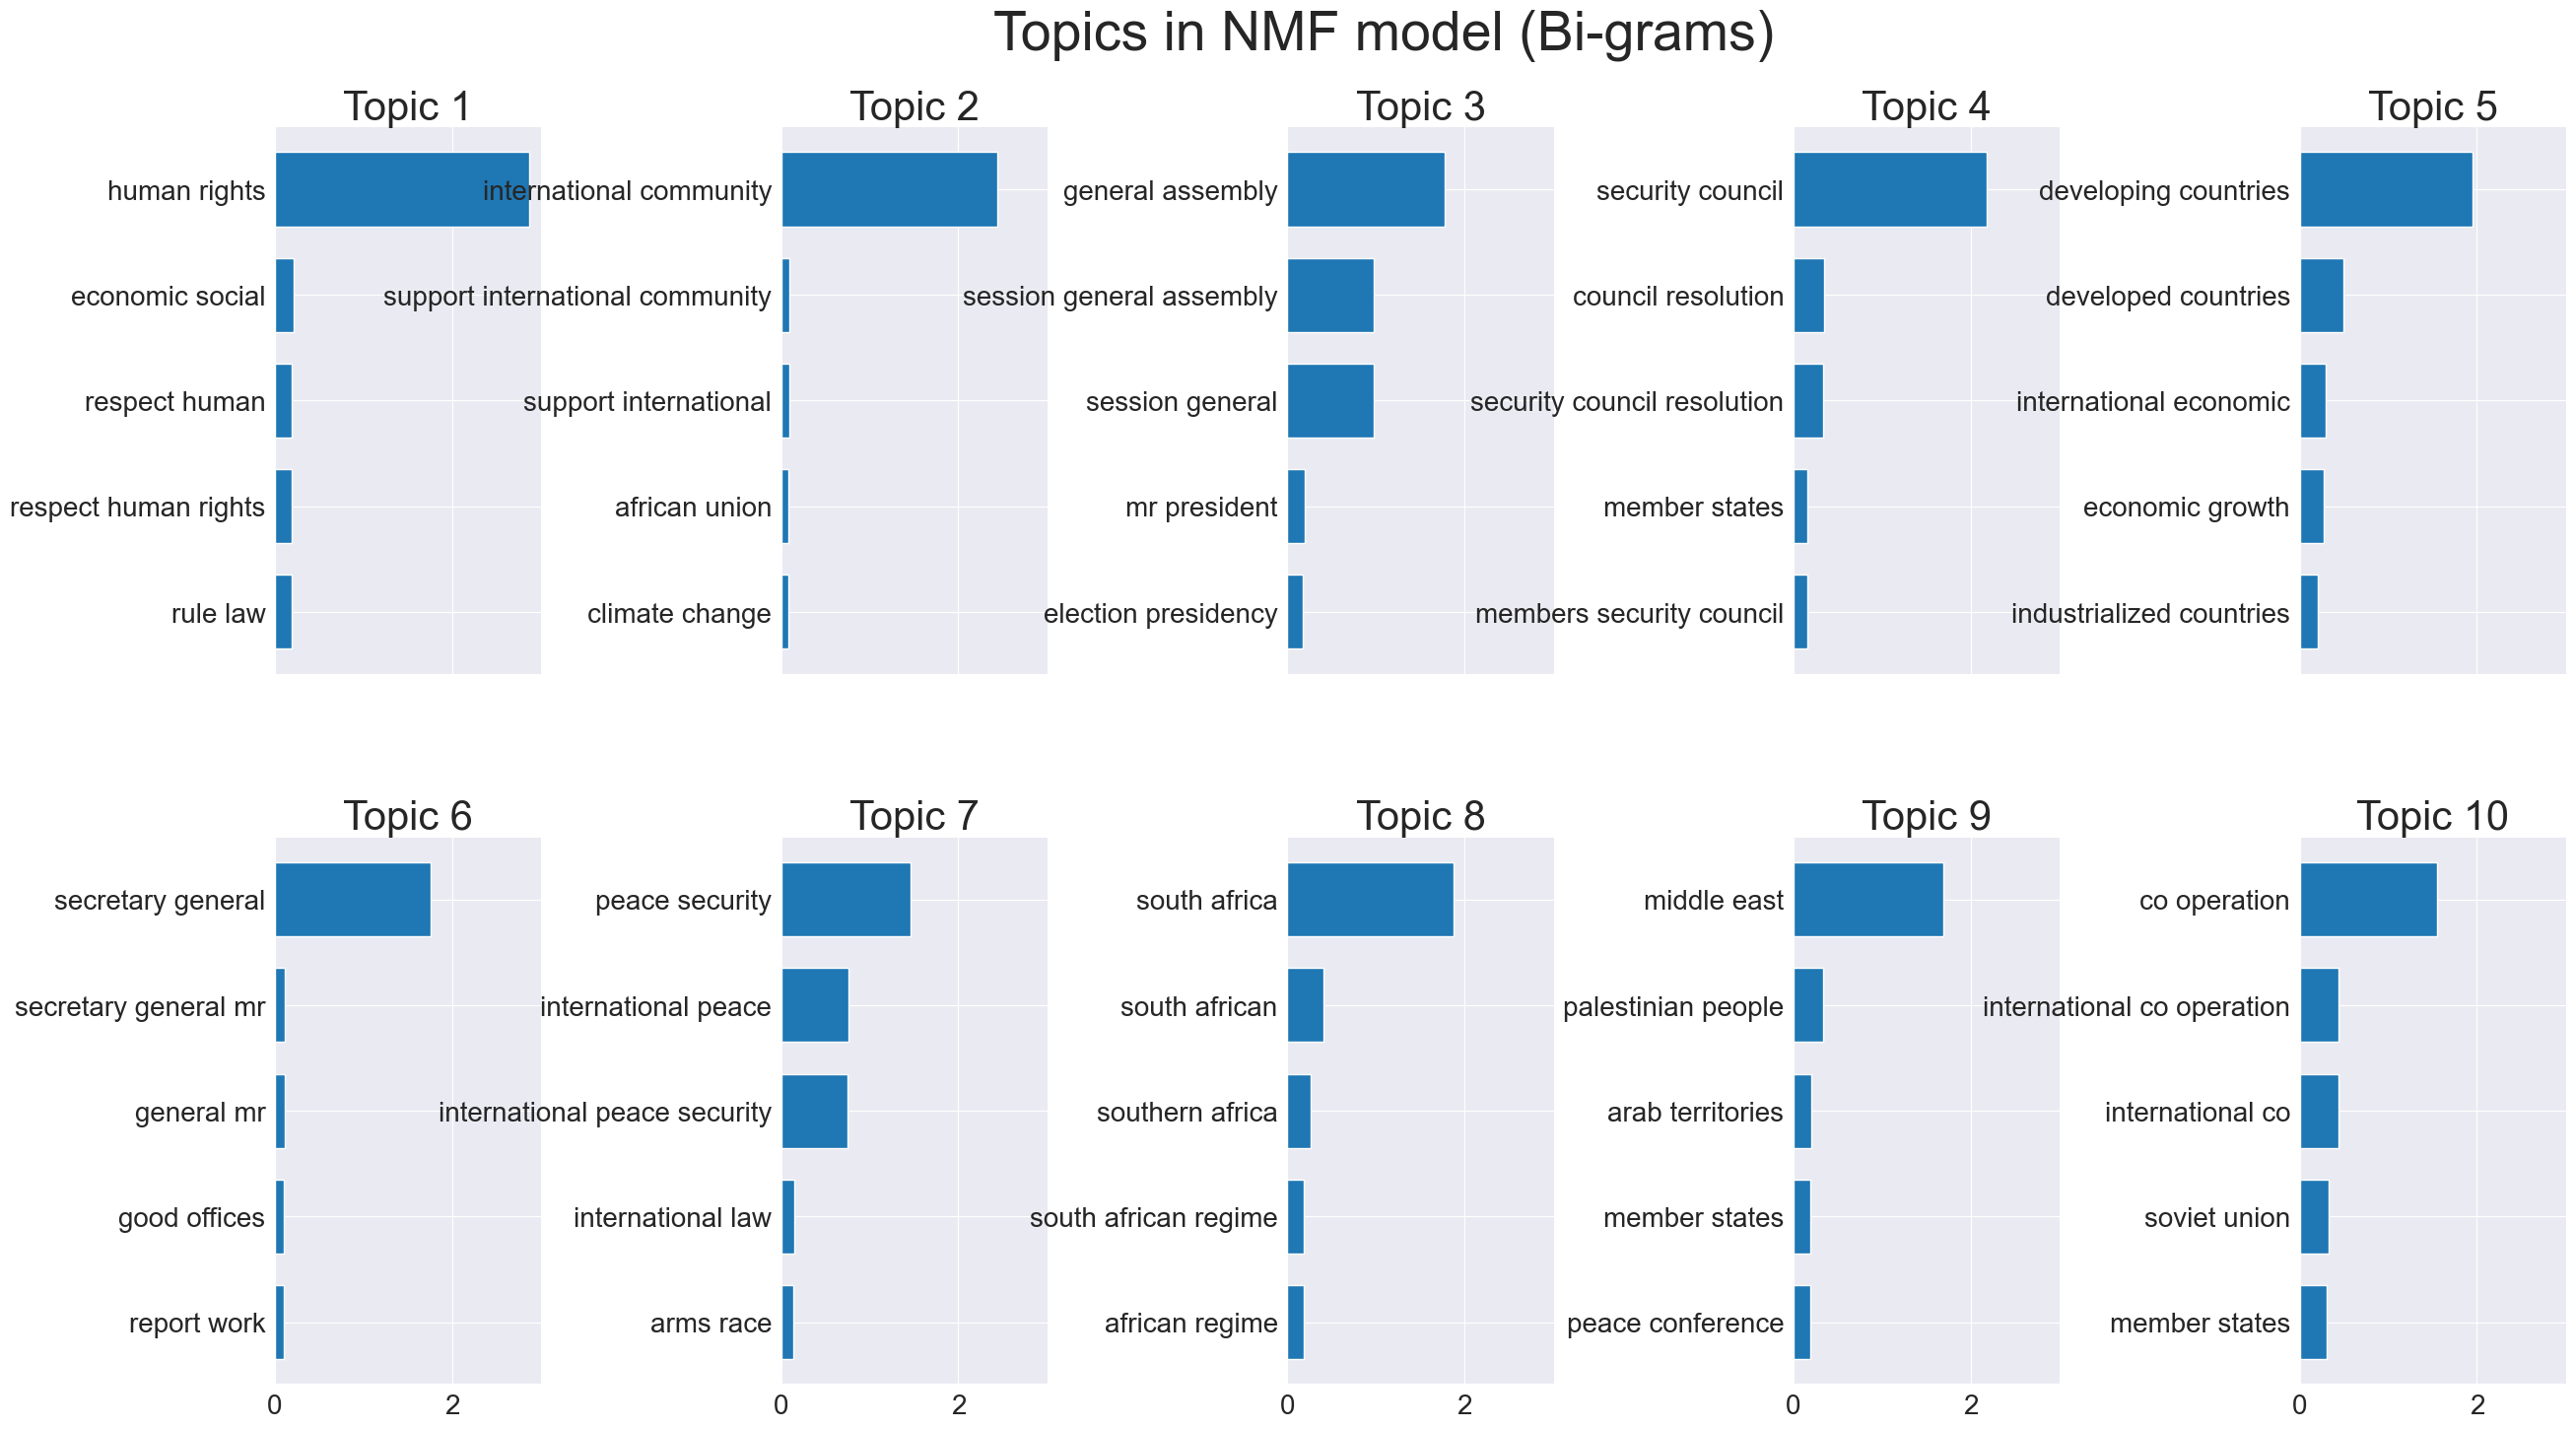

In [238]:
plot_top_words(
    model=nmf_bigrams,
    feature_names=tfidf_vectorizer_bigrams.get_feature_names_out(),
    n_top_words=5,
    title="Topics in NMF model (Bi-grams)"
)

https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py

---

Neither the book nor the example above uses TF-IDF with LDA, but do not specify why. Both use TF-IDF with NMF and then change to CountVectorizer with LDA


https://stackoverflow.com/questions/44781047/necessary-to-apply-tf-idf-to-new-documents-in-gensim-lda-model/44789327#44789327

> LDA only needs a bag-of-word vector.



In [74]:
from sklearn.feature_extraction.text import CountVectorizer
count_para_vectorizer_bigrams = CountVectorizer(stop_words=stopwords, min_df=5, max_df=0.7, ngram_range=(2,3))
count_para_vectors_bigrams = count_para_vectorizer_bigrams.fit_transform(paragraphs["text"])
count_para_vectors_bigrams.shape

/Users/shanekercheval/repos/nlp-template/.venv/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(279045, 396733)

In [66]:
from sklearn.feature_extraction.text import CountVectorizer
count_para_vectorizer_bigrams = CountVectorizer(stop_words=stopwords, min_df=5, max_df=0.7, ngram_range=(2,3))
count_para_vectors_bigrams = count_para_vectorizer_bigrams.fit_transform(paragraphs["text"])
count_para_vectors_bigrams.shape


from sklearn.feature_extraction.text import CountVectorizer
count_para_vectorizer = CountVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
count_para_vectors = count_para_vectorizer.fit_transform(paragraphs["text"])
count_para_vectors.shape

/Users/shanekercheval/repos/nlp-template/.venv/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(279045, 25162)

In [67]:
from sklearn.decomposition import LatentDirichletAllocation

lda_para_model = LatentDirichletAllocation(n_components = 10, random_state=42)
W_lda_para_matrix = lda_para_model.fit_transform(count_para_vectors)
H_lda_para_matrix = lda_para_model.components_

/Users/shanekercheval/repos/nlp-template/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


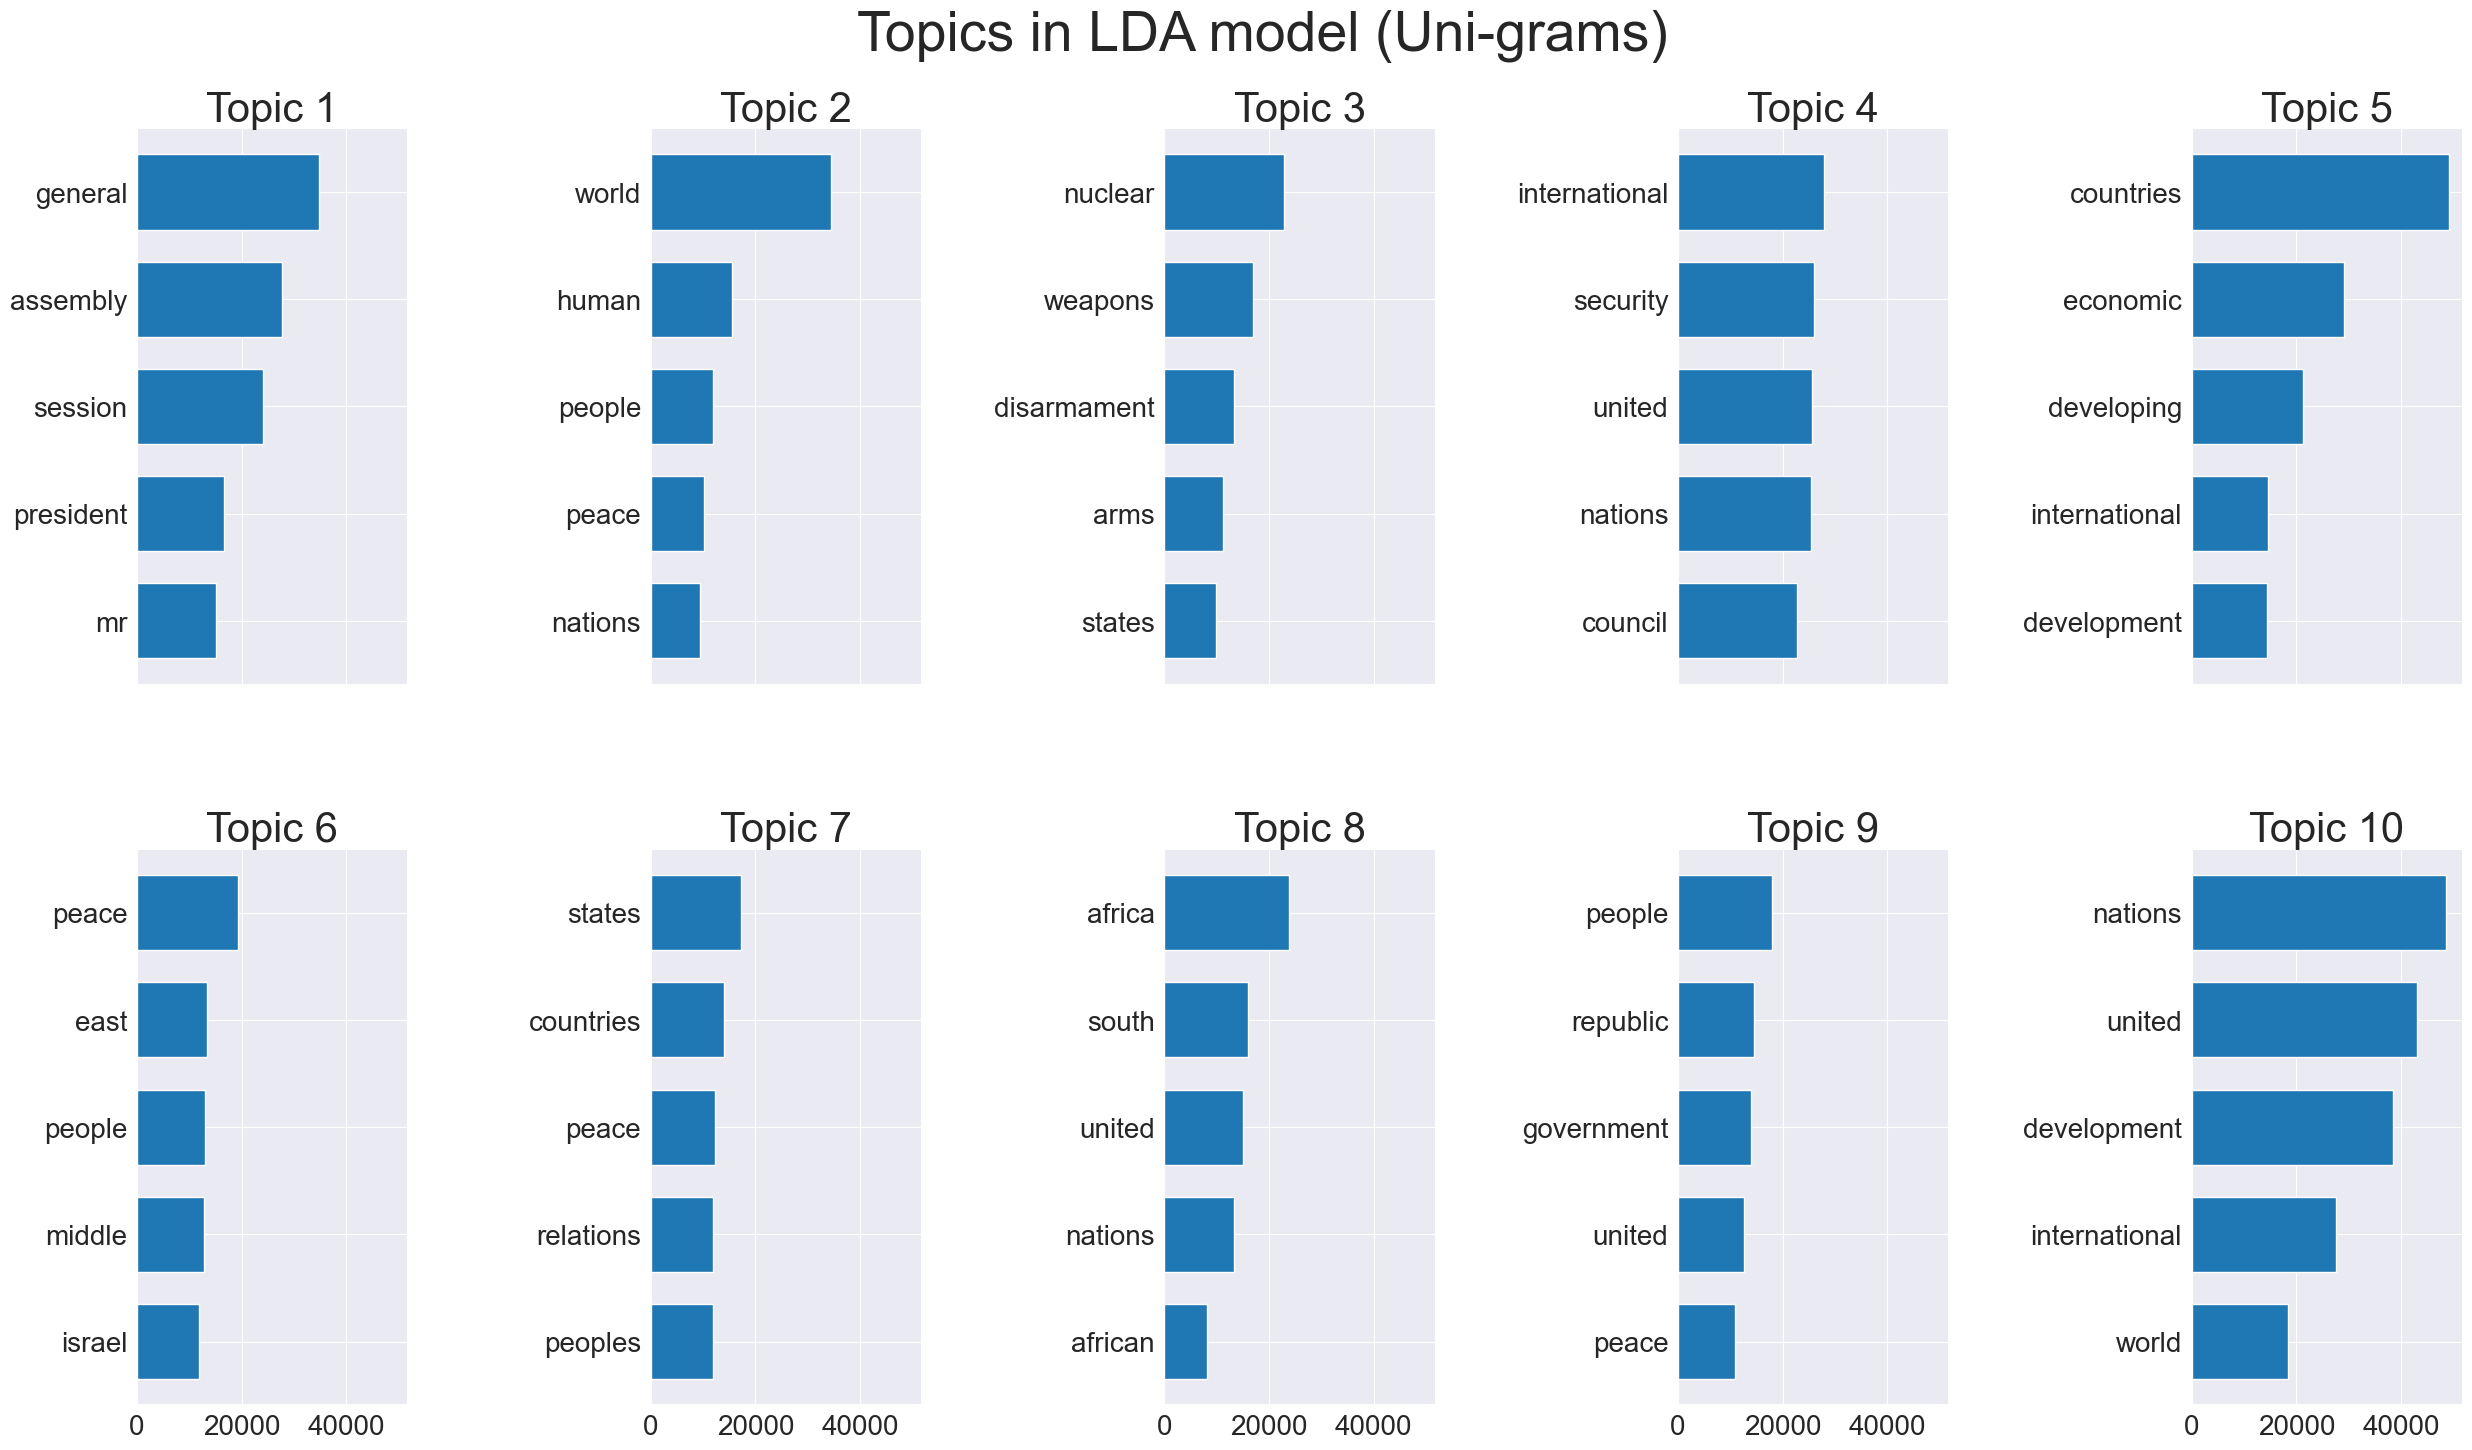

In [71]:
plot_top_words(
    model=lda_para_model,
    feature_names=count_para_vectorizer.get_feature_names_out(),
    n_top_words=5,
    title="Topics in LDA model (Uni-grams)"
)

In [68]:
W_lda_para_matrix.sum(axis=0)/W_lda_para_matrix.sum()*100.0

array([ 9.14716924, 13.03694125,  7.012396  , 11.32457192,  9.2946125 ,
        8.86826234,  8.94118744,  7.10875204,  9.61481304, 15.65129423])

In [75]:
from sklearn.decomposition import LatentDirichletAllocation

lda_para_model_bigrams = LatentDirichletAllocation(n_components = 10, random_state=42)
W_lda_para_matrix_bigrams = lda_para_model_bigrams.fit_transform(count_para_vectors_bigrams)
H_lda_para_matrix_bigrams = lda_para_model_bigrams.components_

In [ ]:
import matplotlib.pyplot as plt
def plot_top_words(model, feature_names, n_top_words, title):
    """
    https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py
    """
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()




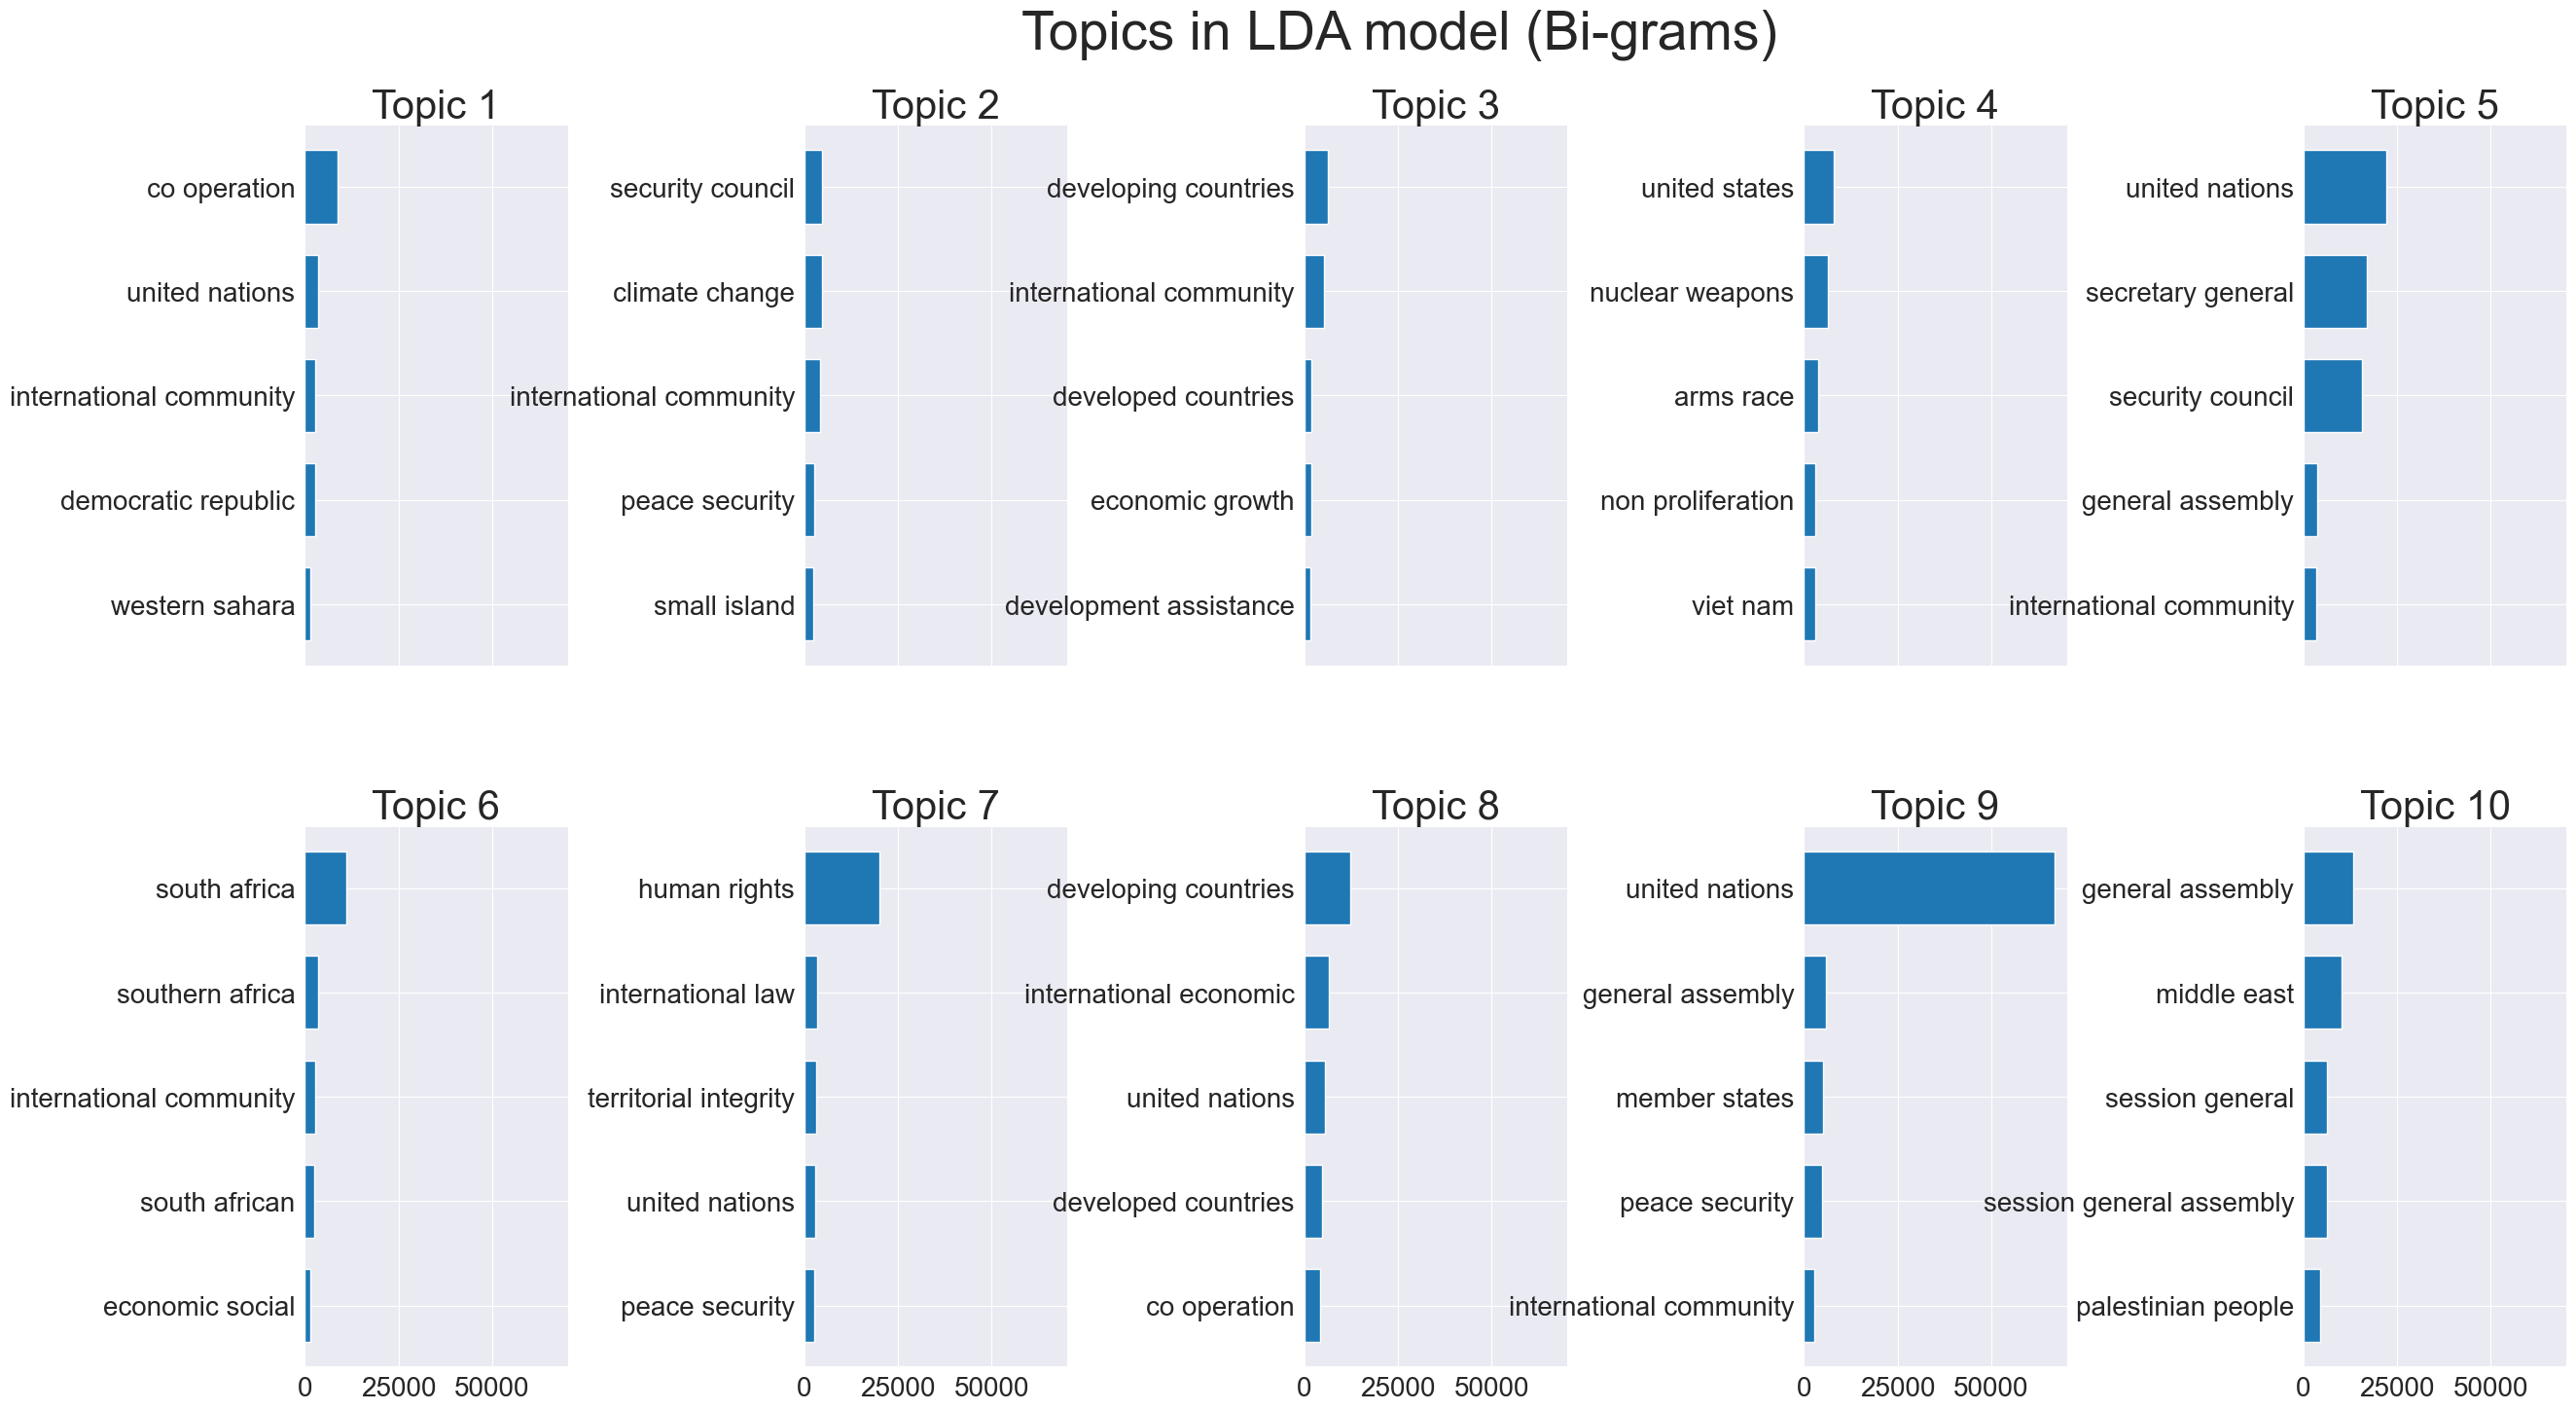

In [82]:
plot_top_words(
    model=lda_para_model_bigrams,
    feature_names=count_para_vectorizer_bigrams.get_feature_names_out(),
    n_top_words=5,
    title="Topics in LDA model (Bi-grams)"
)

In [81]:
import pyLDAvis.sklearn

lda_display = pyLDAvis.sklearn.prepare(lda_para_model, count_para_vectors, count_para_vectorizer, sort_topics=False)
#pyLDAvis.display(lda_display)
pyLDAvis.save_html(lda_display, 'docs/models/lda.html')

In [83]:
import pyLDAvis.sklearn

lda_display = pyLDAvis.sklearn.prepare(lda_para_model_bigrams, count_para_vectors_bigrams, count_para_vectorizer_bigrams, sort_topics=False)
#pyLDAvis.display(lda_display)
pyLDAvis.save_html(lda_display, 'docs/models/lda_bigrams.html')

/Users/shanekercheval/repos/nlp-template/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/shanekercheval/repos/nlp-template/.venv/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/shanekercheval/repos/nlp-template/.venv/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/shanekercheval/repos/nlp-template/.venv/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is depre

/Users/shanekercheval/repos/nlp-template/.venv/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/shanekercheval/repos/nlp-template/.venv/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/shanekercheval/repos/nlp-template/.venv/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/shanekercheval/repos/nlp-template/.venv/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/shanekercheval/repos/nlp-template/.venv/lib/pytho